# Interaction Maps and the Interaction API

SuperStar uses the same underlying knowledge-base of intermolecular interaction preferences as IsoStar. It can be used to analyse potential protein binding sites or small molecules for regions where complementary interacting groups might lie. This functionality can also be accessed _via_ the [Interaction API](https://downloads.ccdc.cam.ac.uk/documentation/API/descriptive_docs/interaction_map_analysis.html).

We will also use the [Protein API](https://downloads.ccdc.cam.ac.uk/documentation/API/descriptive_docs/protein.html) to set up the binding site analysis and the [Utilities API](https://downloads.ccdc.cam.ac.uk/documentation/API/descriptive_docs/utilities.html) to postprocess the results. 

The interaction maps will be inspected in PyMOL.

In [ ]:
import logging
from pathlib import Path
from platform import platform
import sys
import os
from time import time
import subprocess

import warnings

In [ ]:
with warnings.catch_warnings():
    warnings.filterwarnings(action='ignore', category=DeprecationWarning)  # Ignore current 'distutils Version classes are deprecated' warning
    
    import pandas as pd
    
    import plotly.express as px

In [ ]:
from IPython.display import HTML

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [ ]:
import ccdc
from ccdc.protein import Protein
from ccdc.interaction import InteractionMapAnalysis
from ccdc.diagram import DiagramGenerator
from ccdc.io import MoleculeWriter

### Configuration

In [ ]:
hermes_exe = r'C:\Program Files\CCDC\Discovery_2022\Hermes\hermes.exe' 

### Initialization

In [ ]:
logger = logging.getLogger(__name__)

if not logger.hasHandlers():
    handler = logging.StreamHandler()
    handler.setFormatter(logging.Formatter('[%(asctime)s %(levelname)-7s] %(message)s', datefmt='%y-%m-%d %H:%M:%S'))
    logger.addHandler(handler)
    logger.setLevel(logging.INFO)

In [ ]:
logger.info(f"""
Platform:                     {platform()}

Python exe:                   {sys.executable}
Python version:               {'.'.join(str(x) for x in sys.version_info[:3])}

CSD version:                  {ccdc.io.csd_version()}
CSD directory:                {ccdc.io.csd_directory()}
API version:                  {ccdc.__version__}

CSDHOME:                      {os.environ.get('CSDHOME', 'Not set')}
CCDC_LICENSING_CONFIGURATION: {os.environ.get('CCDC_LICENSING_CONFIGURATION', 'Not set')}
""")

Set up a CCDC Diagram Generator...

In [ ]:
diagram_generator = DiagramGenerator()

diagram_generator.settings.return_type = 'SVG'
diagram_generator.settings.explicit_polar_hydrogens = False
diagram_generator.settings.shrink_symbols = False

Utility to help with display in JupyterLab...

In [ ]:
show_df = lambda df: df.style.set_properties(**{'text-align': 'left'})

### Analysis of a protein binding site

First we read a PDB file ([2uw7](https://www.ebi.ac.uk/pdbe/entry/pdb/2uw7)) and create a protein object...

In [ ]:
pdb_file = 'pdb2uw7.ent'

In [ ]:
protein = Protein.from_file(pdb_file)

What ligands are present in this PDB entry?

In [ ]:
[ligand.identifier for ligand in protein.ligands]

We will be examining the binding site around the ligand `A/GVP`...

In [ ]:
ligand = protein.ligands[0]

ligand.identifier

In [ ]:
HTML(diagram_generator.image(ligand))

First, we set up the binding site analysis using a `ProteinSettings` object...

In [ ]:
settings = InteractionMapAnalysis.ProteinSettings()

Set the working directory, _i.e._ where the output directory is to be created (note that an absolute path is required)...

In [ ]:
settings.working_directory = Path('.').absolute()

By default, the whole protein will be searched for cavities.

Instead, we will use a cavity based on the residues around the chosen ligand...

In [ ]:
settings.detect_cavities = False

settings.detect_cavity_from_residues = Protein.BindingSiteFromMolecule(protein, ligand, 6.0)

We will use the CSD as the source for scatterplot data...

In [ ]:
settings.source = 'CSD'

We will use all three probes available by default...

In [ ]:
settings.probe_names

We wish to generate a contour surface and rotate terminal -X-H groups on the protein (_e.g._ in Ser, Thr, Tyr, Cys and Lys residues)...

In [ ]:
settings.calculate_contour_surface = True

settings.rotate_torsions = True # For rotatable OH, SH and NH groups on the protein

Perform the analysis...

In [ ]:
%%time

analyser = InteractionMapAnalysis(settings=settings)

results = analyser.analyse_protein(protein)

Note that the protein, interaction maps and hotspots (_i.e._ maxima for the interaction maps) are saved by default.

The maps are saved in `acnt` format in the directory `results.directory`...

In [ ]:
results_dir = Path(results.directory)

results_dir.name

[x.name for x in results_dir.glob('*.acnt')]

For instructions on visualising the maps, see section '**9.7 Visualising Contoured Surfaces**' of the [Hermes User Guide](https://www.ccdc.cam.ac.uk/support-and-resources/ccdcresources/Hermes_User_Guide_2020_1.pdf).

In [ ]:
status = subprocess.Popen([hermes_exe, pdb_file], creationflags=0x00000008)

Shown below is a single contour level for each of the `Aromatic_CH_Carbon` map (grey) and the `Carbonyl_Oxygen` map (red)...

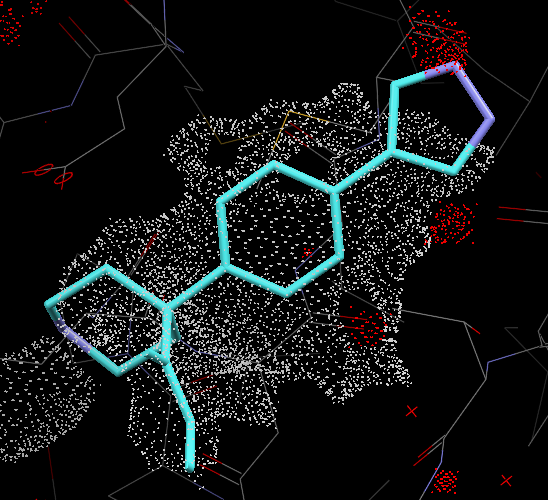

Note that z-clipping hides some of the ligand.

### Analysis of a Small Molecule

It is also possible to analyse a small molecule, independently of a protein.

We now use the SmallMoleculeSettings class instead of the ProteinSettings class...

In [ ]:
settings = InteractionMapAnalysis.SmallMoleculeSettings()

Again, we use all probes available by default...

In [ ]:
settings.probe_names

Perform the analysis...

In [ ]:
ligand

In [ ]:
analyser = InteractionMapAnalysis(settings=settings)

ligand.identifier = ligand.identifier.replace(':', '_')  # We need to fix the ligand name to make it useable in a file-name

results = analyser.analyse_small_molecule(ligand)

In [ ]:
mol_file = ligand.identifier + '.mol'

with MoleculeWriter(mol_file) as writer:
    
    writer.write(ligand)

In [ ]:
status = subprocess.Popen([hermes_exe, mol_file], creationflags=0x00000008)

Shown below is a single contour level for each of the `Aromatic_CH_Carbon` map (grey) and the `Carbonyl_Oxygen` map (red)...

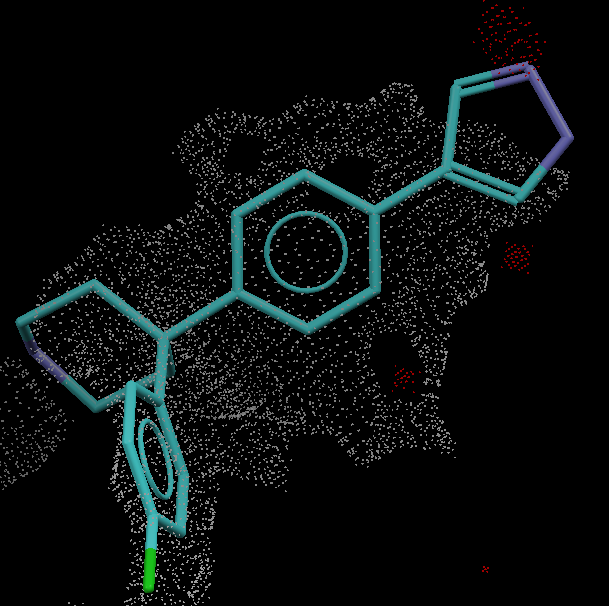